# This is the main notebook for this project

The goal is to evaluate autoencoder-based clustering methods for unsupervised classification of synthetic seismograms. By examining several autoencoder structures and clustering algorithms, we hope to understand if these autoencoder-based methods are sensitive to the features of the seismogram source mechanics.  

A variety of deep-learning algorithms have been developed for clustering images (see https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8412085 for a survey of deep learning clustering algorithms.) One category of deep learning clustering algorithms uses autoencoders - neural networks that learn to recreate the source input while creating an intermediate lower-dimensional embedding.  Autoencoders consist of an encoder that transforms an input (in our case a spectrogram) into a lower-dimensional "embedding" or "latent" vector. The other half of the autoencoder - the decoder - then learns to translate the embedding vector into a recreation of the source data. The network is trained end-to-end with the loss being the difference between the original input and the output.  Two autoencoder methods have inspired the architecture in this project: Deep Convolutional Embedded Clustering (https://xifengguo.github.io/papers/ICONIP17-DCEC.pdf); and Wavenets (https://arxiv.org/abs/1609.03499). 

(Add a bunch of pictures about the structure of these things.)

Deep convolutional embedded clustering (DCEC) employs convolutional neural network layers (convnets) for the encoder and decoder.  Convnets have proven to be very successful for image classification in part because they have properties of translation and scale invariance.  DCEC trains a convolutional autoencoder, and clusters the data based on the latent vector created by the embedding layer.  After pretraining the network without clustering for ~200 epochs, the network is then trained with a joint reconstruction and clustering loss until convergence (see the DCEC paper above for a definition of the clustering loss).  

Wavenets are speech generation neural networks that are pretrained using an autoencoder. Wavenets also use convolutional layers, but of a specific type termed "causal" or "temporal". While a traditional convnet employs convolutional filters that are symmetric in space, causal convnet filters only depend on previous time steps.   Wavenets have been very successful at generating realistic human speech and are used by Google for text to speech.

This project proposes a modification to DCEC that replaces the convnets with causal convnets to preserve the temporal structure of the data.  Both regular and causal DCEC archtiectures are used to cluster spectrograms from synthetic seismograms, to asses the clustering performance of both.  Future work could entail clustering based on the full waveform, but for now the dimensionality reduction performed by the spectrogram creation makes training much quicker.  



We investigate three main areas.  Each area evaluates the pefromance of both regular and causal DCEC:

 - **Experiment 1.** Ability for autoencoder clustering (AEC) to determine the earthquake *source mechanism* from a spectrogram. 
      - Double couple, compensated linear vector dipole, and isotropic impulse sources will be used to generate synthetic seismograms with random nodal plane orientations
      - Clustering will be performed using casual and acausal DCEC.  Accuracy assessed by correct clustering of source mechanism.  Sensitivity of cluster to nodal plane orientation (if applicable - obviously an isotropic source won't have a nodal plane orientation) will also be assessed.
    
    
 - **Experiment 2.** Ability for AEC to determine the *source time function* class 
      - Lognormal, boxcar, and triangular source time functions will be used to generate seismograms with a single source mechanism type (double couple - DC), random nodal plane orientation, and varying durations (1 - 10 seconds).
      - Clustering will be performed using casual and acausal DCEC. Accuracy assessed by correct clustering of source time function.
    
    
 - **Experiment 3.** Ability for AEC to determine *noise statistics* of the source time function 
     - A lognormal source time function with gaussian and gutenberg-richter (i.e., power law) noise will be used with a single source mechanism (DC) and random nodal planes.
     - Clustering will be performed using casual and acausal DCEC. Accuracy assessed by correct clustering of noise type.  
     
     
 - **Experiment 4.** Put it all together and see what they are most sensitive to 
      - Look at the silhouette scores for different numbers of clusters?

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from IPython.display import Image
from IPython.display import display

# Experiment 1

 - Ability for autoencoder clustering (AEC) to determine the earthquake *source mechanism* from a spectrogram. 

      - Double couple, compensated linear vector dipole, and isotropic impulse sources will be used to generate synthetic seismograms with random nodal plane orientations
      
      - Clustering will be performed using casual and acausal DCEC.  Accuracy assessed by correct clustering of source mechanism.  Sensitivity of cluster to nodal plane orientation (if applicable - obviously an isotropic source won't have nodal plane orientations) will also be assessed.

### Example synthetic seimograms and spectrograms

See synthetic_seismograms.ipynb for further details on creating synthetic seismograms.  Below are examples of the synthetic seismograms and spectrograms created for the clustering dataset.

In [3]:
with open('Experiment1/synthetics.pkl','rb') as f:
    synthetics1 = pickle.load(f)

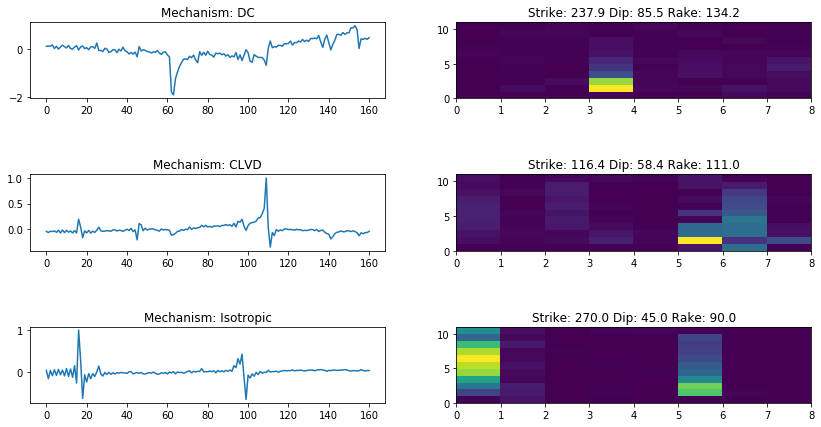

In [29]:
f, axes = plt.subplots(3,2, figsize=(14,7))

for i, n in enumerate([10, 2010, 4010]):
    axes[i,0].plot(synthetics1['seismograms'][n])
    axes[i,0].set_title('Mechanism: {}'.format(synthetics1['source_mechanisms'][n]))
    axes[i,1].pcolormesh(synthetics1['spectrograms'][n])
    s, d, r = synthetics1['strike_dip_rakes'][n][0]
    axes[i,1].set_title('Strike: {:0.1f} Dip: {:0.1f} Rake: {:0.1f}'.format(s,d,r))
    
plt.subplots_adjust(hspace=1)

## 1. Overall accuracy is pretty consistent among all algorithms, around 70%.  

 - Causal algorithms are slightly better, although this is for one run each so there is no info on statistical significance yet.

 - Skip connections are slightly worse, by a fraction of a percent.  Unknown if significant.

 - Acasual with skip connections fares slightly better on the mutual information and adjusted rand index scores.

In [31]:
pd.read_csv('Experiment1/clustering_metrics_results.csv')

,Unnamed: 0,algorithm,skips,acc,nmi,ari,silhouette
0,0,causal,True,0.71400,0.56964,0.50620,0.982156
1,1,causal,False,0.71883,0.57732,0.50960,0.967680
2,2,acausal,True,0.70200,0.60011,0.52301,0.963885
3,3,acausal,False,0.70683,0.57652,0.50893,0.968842


## 2. Isotropic sources are clustered into their own cluster very well by all algorithms, with only a few CLVD sources leaking into the Isotropic cluster. Example is from acausal net, no skip connections

In [51]:
pd.read_csv('Experiment1/causal_skipsFalse/sourcemech_by_cluster.csv')

,cluster_assignments,source_mechanisms,Count
0,0,CLVD,696
1,0,DC,968
2,1,CLVD,62
3,1,DC,1
4,1,Isotropic,2000
5,2,CLVD,1242
6,2,DC,1031


## 3. Dip angle seems to be the deciding factor for clustering when considering DC and CLVD sources.
 
 - However, this is when dip, strike, and rake are considered independently. There may be a more complicated interplay that this analysis doesn't see.
 
 - TODO: Plot nodal plane normals on a stereonet to see if the clusters have a preferred orientation (I bet they do.  I suspect this algorithm clusters more on source orientation than source mechanism.)

 - TODO: Analysis of source mechanism, dip, strike, and rake angles for prediction of the cluster class.  Can use a logistic rtegression or a tree-based algorithm to look at importance of variables.

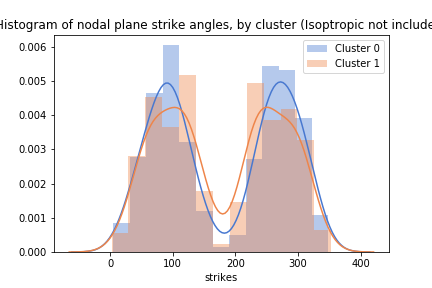

In [44]:
Image('Experiment1/acausal_skipsTrue/strike-histogram.png')


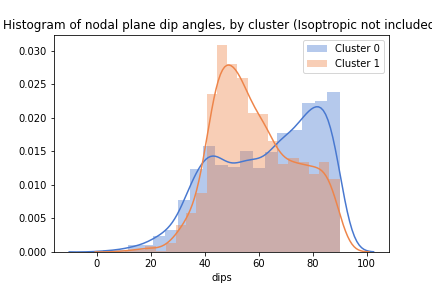

In [47]:
Image('Experiment1/acausal_skipsTrue/dip-histogram.png')

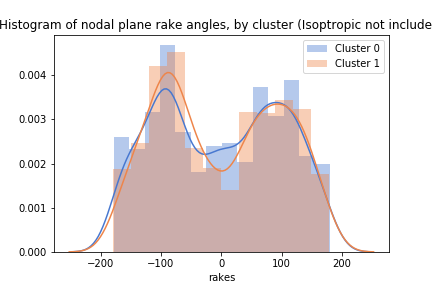

In [48]:
Image('Experiment1/acausal_skipsTrue/rake-histogram.png')

### Source mechanisms and clusters in t-sne space

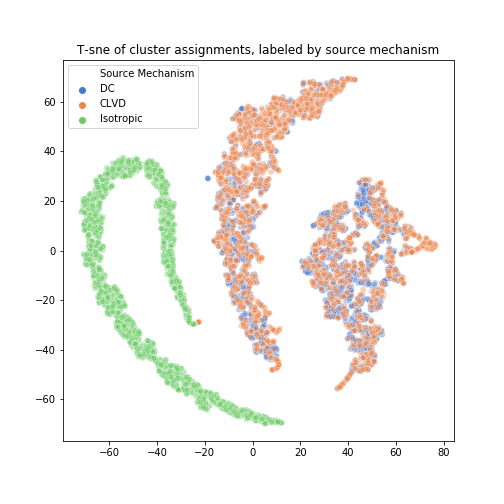

In [52]:
Image('Experiment1/causal_skipsTrue/tsne-mechanisms.png')

# Experiment 2

 - Ability for AEC to determine the *source time function* class 
 
      - Lognormal, boxcar, and triangular source time functions will be used to generate seismograms with a single source mechanism type (double couple - DC), random nodal plane orientation, and varying durations (1 - 10 seconds).
      
      - Clustering will be performed using casual and acausal DCEC. Accuracy assessed by correct clustering of source time function.

### Example synthetic seismograms

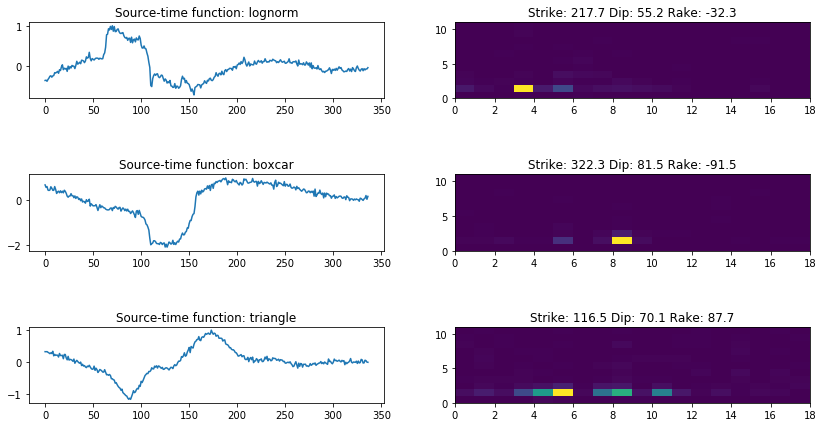

In [54]:
with open('Experiment2/synthetics.pkl','rb') as f:
    synthetics2 = pickle.load(f)
    
f, axes = plt.subplots(3,2, figsize=(14,7))

for i, n in enumerate([10, 2010, 4010]):
    axes[i,0].plot(synthetics2['seismograms'][n])
    axes[i,0].set_title('Source-time function: {}'.format(synthetics2['stfs'][n]))
    axes[i,1].pcolormesh(synthetics2['spectrograms'][n])
    s, d, r = synthetics2['strike_dip_rakes'][n][0]
    axes[i,1].set_title('Strike: {:0.1f} Dip: {:0.1f} Rake: {:0.1f}'.format(s,d,r))
    
plt.subplots_adjust(hspace=1)

## 1. Overall accuracy (based on source time function type) is wildly inconsistent, and not significantly different between the algorithms.  

Seismograms were clustered multiple time by each algorithm.  Below is a boxplotplot of the range of accuracies by algorithm.

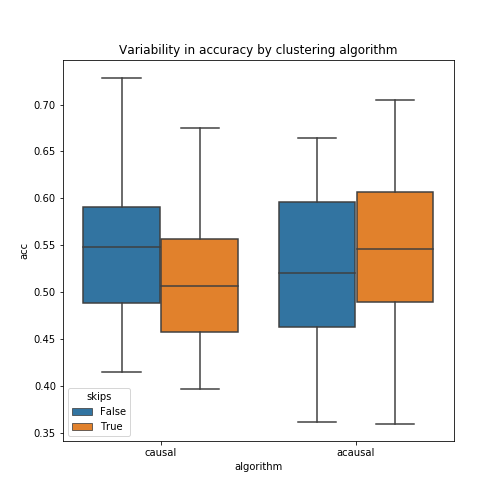

In [55]:
Image('Experiment2/accuracy-variability.png')

### Confusion matrix for clustering.

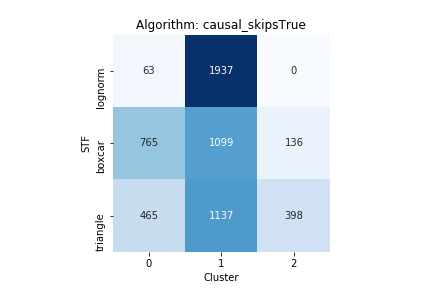

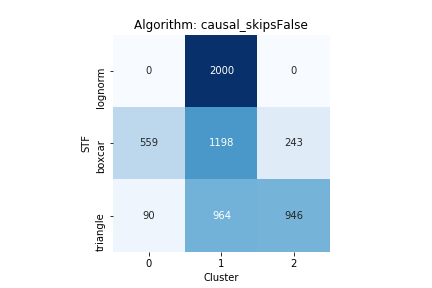

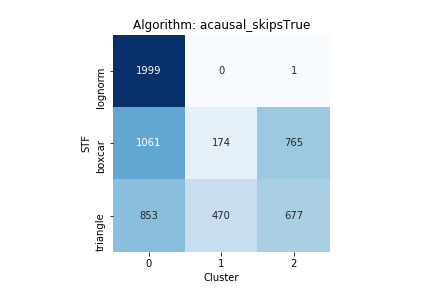

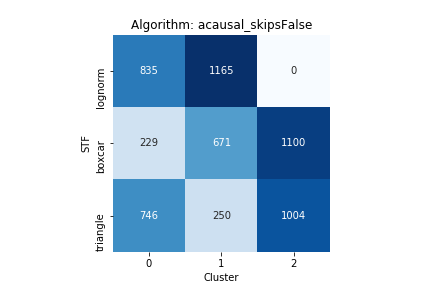

In [62]:
algos = ['causal_skipsTrue','causal_skipsFalse','acausal_skipsTrue','acausal_skipsFalse']
images = [Image('Experiment2/{}/confusion-matrix.png'.format(algo)) for algo in algos]

for image in images: display(image)


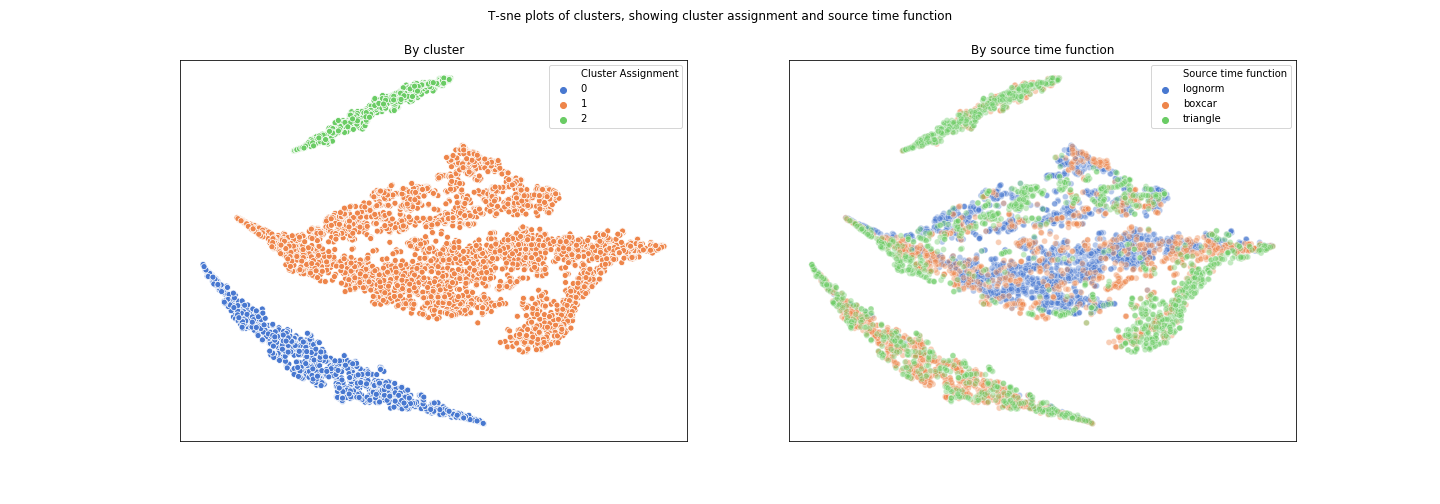

In [68]:
Image('Experiment2/causal_skipsTrue/tsne-clusters.png')

## 2. Clusters have no dependence on nodal plane orientation.

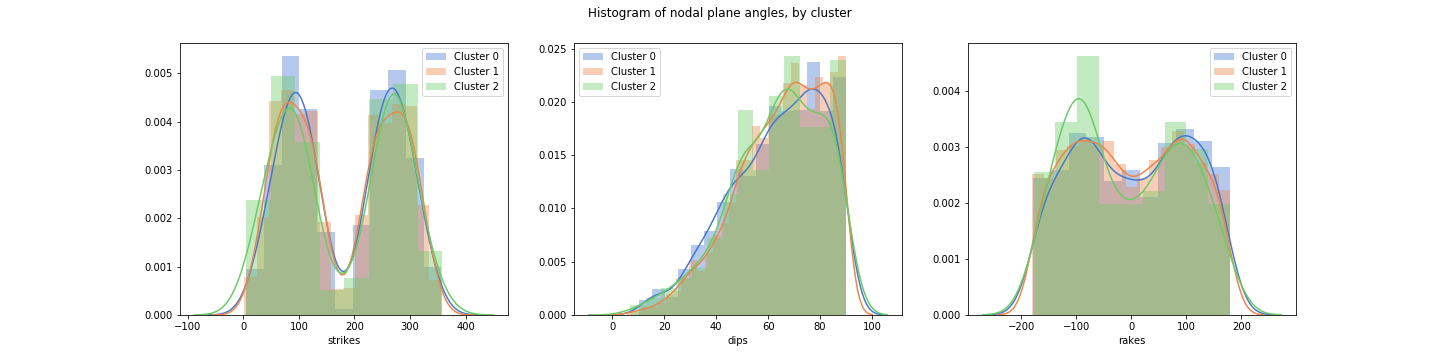

In [69]:
Image('Experiment2/causal_skipsTrue/nodalplane-histogram.png')

## 3. Clustering appears to be most sensitive to duration of the source time function

But the sensitivity varies, being greatest with the acausal no skips algorithm.



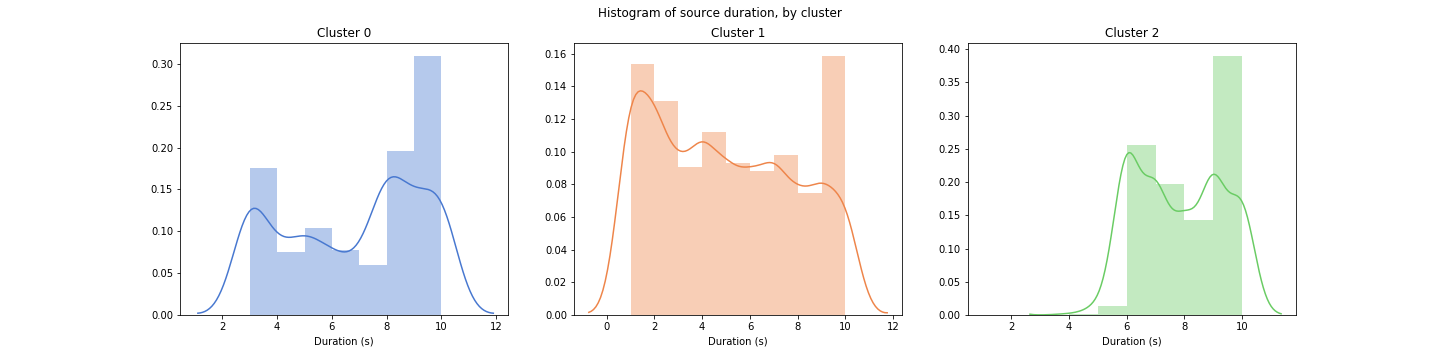

In [70]:
Image('Experiment2/causal_skipsTrue/duration-histogram.png')

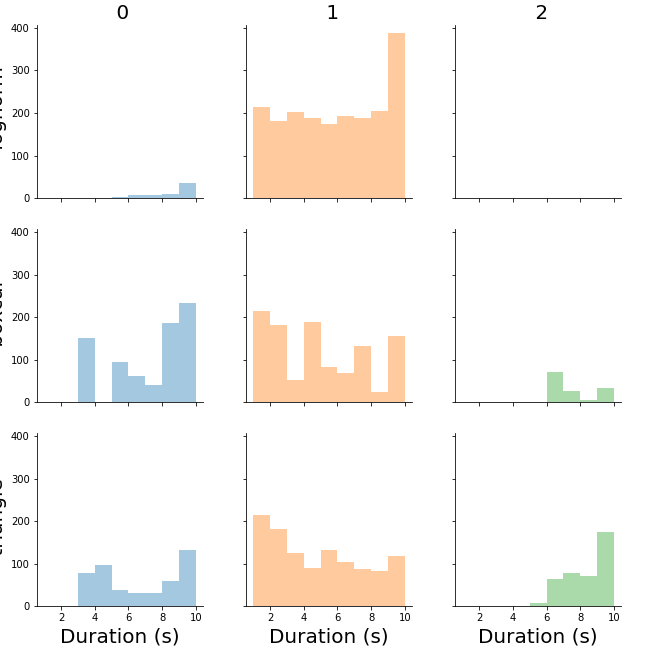

In [73]:
Image('Experiment2/causal_skipsTrue/stf_duration-histogram.png')

# Experiment 3

 - Ability for AEC to determine *noise statistics* of the source time function 
     - A lognormal source time function with gaussian and gutenberg-richter noise will be used with a single source mechanism (DC) and random nodal planes.
     - Clustering will be performed using casual and acausal DCEC. Accuracy assessed by correct clustering of noise type. 

### Example synthetic seismograms

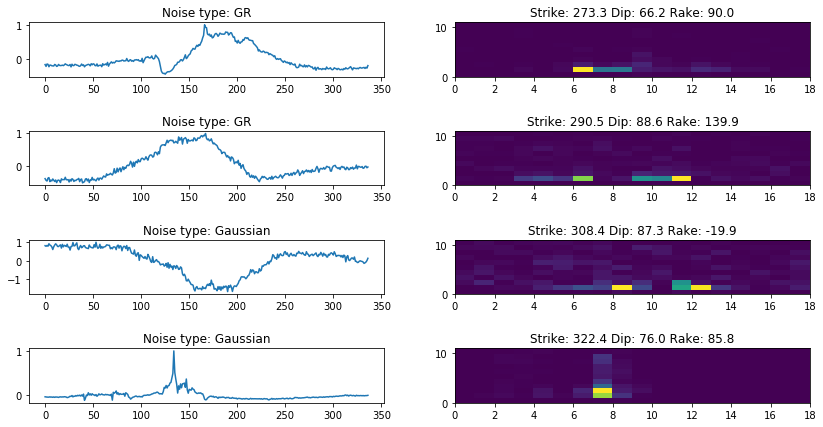

In [74]:
with open('Experiment3/synthetics.pkl','rb') as f:
    synthetics3 = pickle.load(f)
    
f, axes = plt.subplots(4,2, figsize=(14,7))

for i, n in enumerate([10, 1000, 3010, 4010]):
    axes[i,0].plot(synthetics3['seismograms'][n])
    axes[i,0].set_title('Noise type: {}'.format(synthetics3['noise_types'][n]))
    axes[i,1].pcolormesh(synthetics3['spectrograms'][n])
    s, d, r = synthetics3['strike_dip_rakes'][n][0]
    axes[i,1].set_title('Strike: {:0.1f} Dip: {:0.1f} Rake: {:0.1f}'.format(s,d,r))
    
plt.subplots_adjust(hspace=1)

Experiments aren't done yet